# Histopathologic Cancer Detection — ResNet50 High-Score Pipeline

## Abstract
This notebook addresses the *Histopathologic Cancer Detection* challenge by
developing a high-performing deep learning pipeline. We utilize a ResNet50
pretrained on ImageNet, adapt it to the binary classification task, and apply
techniques to mitigate class imbalance. To further improve performance, we
incorporate strong data augmentations, AUC-based early stopping, and test-time
augmentation (TTA). Validation-driven threshold tuning is used to maximize
generalization to the hidden test set. This notebook is structured in an
academic style, with clear sections for motivation, methodology, experiments,
and conclusions.


## Introduction
Histopathologic image analysis plays a critical role in cancer diagnostics. In
this competition, the goal is to classify small image patches (96×96 pixels) as
containing cancerous tissue or not. The dataset is relatively imbalanced, with
fewer positive samples than negative ones, which motivates the use of class-
imbalance remedies.

Our approach leverages a **ResNet50 backbone** pretrained on ImageNet, chosen
for its strong representational power. To enhance generalization, we apply
comprehensive image augmentations and incorporate weighted sampling as well as
loss re-weighting. Model evaluation is guided by the **Area Under the ROC Curve
(AUC)**, a metric robust to imbalance. Furthermore, we apply **test-time
augmentation (TTA)** to stabilize predictions and employ **validation-driven
threshold tuning** to maximize downstream classification performance.


## Data Sanity Check
Before designing the model, it is essential to ensure that the dataset is
correctly mounted in the Kaggle environment. We check the number of training
and test images, inspect the label CSV, and confirm CUDA availability.


In [3]:
import os, glob, itertools, numpy as np, pandas as pd

DATA_DIR = "/kaggle/input/histopathologic-cancer-detection"
WORK_DIR = "/kaggle/working"

assert os.path.exists(f"{DATA_DIR}/train_labels.csv")

n_train = len(glob.glob(f"{DATA_DIR}/train/*.tif"))
n_test  = len(glob.glob(f"{DATA_DIR}/test/*.tif"))
print("DATA_DIR:", DATA_DIR)
print("train images:", n_train, "| test images:", n_test)

df = pd.read_csv(f"{DATA_DIR}/train_labels.csv")
print("labels shape:", df.shape)
display(df.head())

for entry in itertools.islice(os.scandir(os.path.join(DATA_DIR, "test")), 10):
    print(entry.path)

try:
    import torch
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
except Exception:
    pass

DATA_DIR: /kaggle/input/histopathologic-cancer-detection
train images: 220025 | test images: 57458
labels shape: (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
/kaggle/input/histopathologic-cancer-detection/test/5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
/kaggle/input/histopathologic-cancer-detection/test/bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
/kaggle/input/histopathologic-cancer-detection/test/523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
/kaggle/input/histopathologic-cancer-detection/test/d23c66547f4a00555a174d2fcb860ae399b66edc.tif
/kaggle/input/histopathologic-cancer-detection/test/fabf2fca23f71655974767e29eda86a9b2c97a72.tif
/kaggle/input/histopathologic-cancer-detection/test/9730b15862516b8641b9f0ff48db660d95031c32.tif
/kaggle/input/histopathologic-cancer-detection/test/ee85348c0950c2e639776fb555e3452c1f8437c0.tif
/kaggle/input/histopathologic-cancer-detection/test/ef12a0813c504d2d1b2ba485e78d380ad64a0622.tif
CUDA available: True
GPU: Tesl

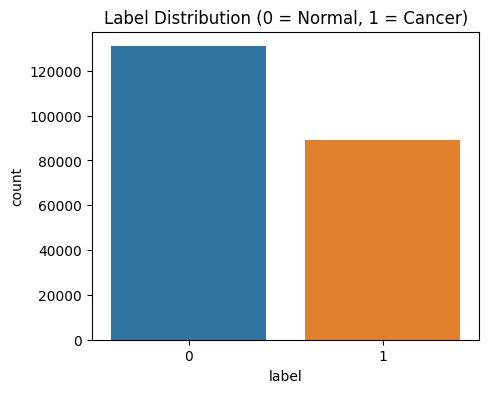

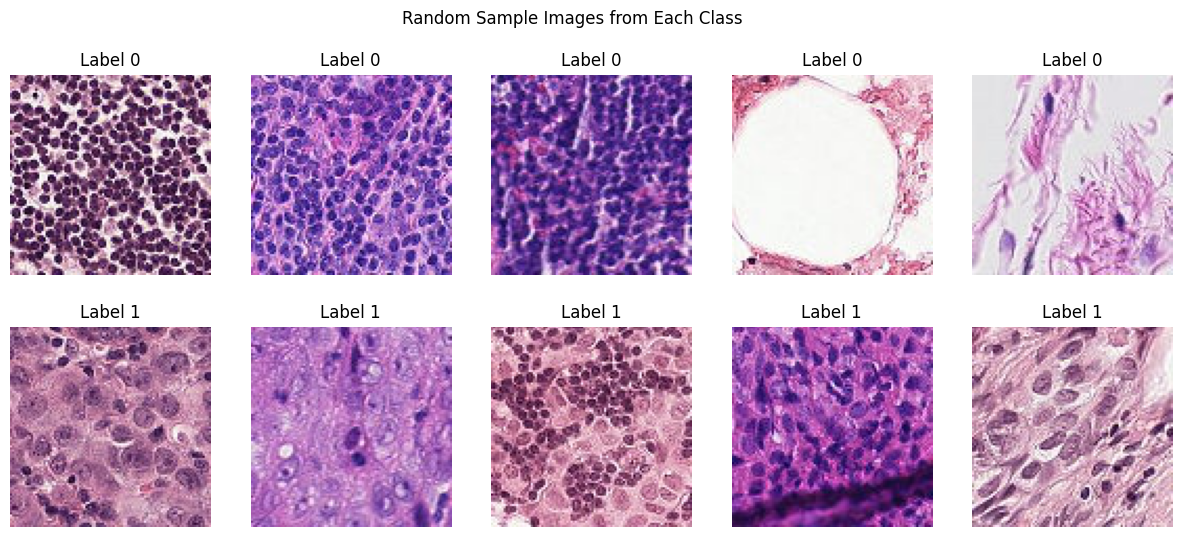

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

labels_df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

plt.figure(figsize=(5,4))
sns.countplot(x="label", data=labels_df)
plt.title("Label Distribution (0 = Normal, 1 = Cancer)")
plt.show()

import random
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i, label in enumerate([0,1]):
    sample_ids = labels_df[labels_df.label==label].sample(5).id.values
    for j, img_id in enumerate(sample_ids):
        path = os.path.join(DATA_DIR, "train", f"{img_id}.tif")
        img = Image.open(path)
        axes[i,j].imshow(img)
        axes[i,j].set_title(f"Label {label}")
        axes[i,j].axis("off")
plt.suptitle("Random Sample Images from Each Class")
plt.show()

## Environment Setup
Reproducibility is critical in machine learning. We set random seeds for all
relevant libraries and configure GPU usage. This ensures that our experiments
are as deterministic as possible across multiple runs.


In [5]:
import os, glob, random, math, time
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

import torchvision.models as models
import torchvision.transforms as T

DATA_DIR = "/kaggle/input/histopathologic-cancer-detection"
WORK_DIR = "/kaggle/working"
assert os.path.exists(os.path.join(DATA_DIR, "train_labels.csv"))

def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

def wrap_dp(model):
    if torch.cuda.device_count() > 1:
        print(f"Using DataParallel with {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    return model

CUDA: True | device: cuda


In [6]:
import torch, torchvision, platform, sys
print("Python:", sys.version)
print("PyTorch:", torch.__version__, "| TorchVision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124 | TorchVision: 0.21.0+cu124
CUDA available: True
GPU: Tesla T4


## Data Preparation
The dataset consists of 96×96 histopathology patches. To mitigate overfitting
and enhance robustness, we apply several augmentations during training,
including random flips, rotations, and color jitter. For validation and testing,
we use deterministic resizing and normalization.

We split the dataset into training and validation sets using **stratified
sampling** to maintain class balance. To address imbalance further, we employ a
**weighted random sampler**, ensuring that positive and negative samples are
sampled more evenly during training.


In [7]:
IMG_SIZE = 96

from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import os

IMG_SIZE = int(globals().get("IMG_SIZE", 96))

class CancerDataset(Dataset):
    def __init__(self, data_df, data_dir, mode="train"):
        self.df = data_df.reset_index(drop=True).copy()
        self.data_dir = data_dir
        self.mode = mode

        if mode == "train":
            self.tf = T.Compose([
                T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.ToTensor(),
                T.Normalize([0.5]*3, [0.5]*3),
            ])
        else:  # valid / test
            self.tf = T.Compose([
                T.Resize((IMG_SIZE, IMG_SIZE)),
                T.ToTensor(),
                T.Normalize([0.5]*3, [0.5]*3),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.mode == "test":
            img_id = str(self.df["id"].iat[idx])
            path = os.path.join(self.data_dir, "test", f"{img_id}.tif")
            img = Image.open(path).convert("RGB")
            return self.tf(img), img_id

        row = self.df.iloc[idx]
        img_id = str(row["id"])
        label  = int(row["label"])
        path = os.path.join(self.data_dir, "train", f"{img_id}.tif")
        img = Image.open(path).convert("RGB")
        return self.tf(img), label

labels = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
train_df, val_df = train_test_split(labels, test_size=0.1, random_state=42, stratify=labels["label"])
print("Split:", train_df.shape, val_df.shape, "| Pos rate:", labels.label.mean())

class_counts = train_df["label"].value_counts().to_dict()
class_weights = {c: len(train_df)/class_counts[c] for c in class_counts}
sample_weights = train_df["label"].map(class_weights).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH_SIZE = 128
num_workers = 2

train_ds = CancerDataset(train_df, DATA_DIR, mode="train")
val_ds   = CancerDataset(val_df,   DATA_DIR, mode="valid")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,  num_workers=num_workers, pin_memory=True)

Split: (198022, 2) (22003, 2) | Pos rate: 0.40503124644926713


## Model and Objective
We adopt **ResNet50** as our backbone network, initialized with pretrained
weights from ImageNet. The final fully connected layer is replaced with a
single-logit head for binary classification.

The loss function is **BCEWithLogitsLoss**, which combines a sigmoid layer and
binary cross-entropy in one step. We additionally use the `pos_weight`
parameter to counter class imbalance by penalizing misclassified positive
samples more heavily. Optimization is performed with **AdamW**, and the learning
rate is scheduled with a **warmup + cosine annealing strategy** to improve
stability in the early epochs.


In [8]:
want_pretrained = True

try:
    if want_pretrained:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        print("Loaded ResNet50 with ImageNet pretrained weights.")
    else:
        model = models.resnet50(weights=None)
        print("Using ResNet50 with random init (no pretrained).")
except Exception as e:
    print("Pretrained weights unavailable, falling back to random init. Reason:", repr(e))
    model = models.resnet50(weights=None)

model.fc = nn.Linear(model.fc.in_features, 1)
model = wrap_dp(model.to(device))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s] 


Loaded ResNet50 with ImageNet pretrained weights.
Using DataParallel with 2 GPUs


In [9]:
if 'train_df' in globals():
    vc = train_df['label'].value_counts()
elif 'labels' in globals():
    vc = labels['label'].value_counts()
else:
    _labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
    vc = _labels['label'].value_counts()

pos = int(vc.get(1, 1))
neg = int(vc.get(0, 1))
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)
print(f"pos_weight = {pos_weight.item():.3f} (neg={neg}, pos={pos})")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

class WarmupCosine(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        super().__init__(optimizer, last_epoch)
    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [base_lr * (self.last_epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]
        t = self.last_epoch - self.warmup_epochs
        T = max(1, self.max_epochs - self.warmup_epochs)
        return [0.5 * base_lr * (1 + math.cos(math.pi * t / T)) for base_lr in self.base_lrs]

EPOCHS = 28
scheduler = WarmupCosine(optimizer, warmup_epochs=2, max_epochs=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

print("Setup done → EPOCHS:", EPOCHS)

pos_weight = 1.469 (neg=117817, pos=80205)
Setup done → EPOCHS: 28


/tmp/ipykernel_36/843125969.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


## Training and Validation
The model is trained for up to 20 epochs with early stopping to prevent
overfitting. After each epoch, performance on the validation set is evaluated
using AUC. Additionally, we scan across thresholds between 0.2 and 0.8 to
determine the validation-optimal decision boundary, which will later be applied
to the test predictions.

This AUC-driven early stopping strategy ensures that we retain the model that
generalizes best, rather than simply the one with lowest training loss.


In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm
import numpy as np

EPOCHS = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0], device=device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_losses, val_losses, val_aucs = [], [], []
all_preds, all_labels = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Train"):
        x = x.to(device)
        y = y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    tr_loss = running_loss / len(train_loader.dataset)
    train_losses.append(tr_loss)

    model.eval()
    v_loss_sum = 0.0
    preds_epoch, labels_epoch = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Val"):
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)

            logits = model(x)
            loss = criterion(logits, y)
            v_loss_sum += loss.item() * x.size(0)

            probs = torch.sigmoid(logits).cpu()
            preds_epoch.append(probs)
            labels_epoch.append(y.cpu())

    preds_epoch = torch.cat(preds_epoch).numpy().ravel()
    labels_epoch = torch.cat(labels_epoch).numpy().ravel()

    v_loss = v_loss_sum / len(val_loader.dataset)
    v_auc  = roc_auc_score(labels_epoch, preds_epoch)

    val_losses.append(v_loss)
    val_aucs.append(v_auc)

    print(f"[Epoch {epoch+1}] Train Loss: {tr_loss:.4f} | Val Loss: {v_loss:.4f} | Val AUC: {v_auc:.4f}")

all_preds  = preds_epoch
all_labels = labels_epoch

ths = np.linspace(0.1, 0.9, 17)
f1s = [f1_score(all_labels, (all_preds > t).astype(int)) for t in ths]
best_threshold = float(ths[int(np.argmax(f1s))])
print(f"Best threshold by F1 on validation: {best_threshold:.2f}")

Epoch 1/3 - Val: 100%|██████████| 172/172 [01:40<00:00,  1.72it/s]


[Epoch 1] Train Loss: 0.3212 | Val Loss: 0.2077 | Val AUC: 0.9860


Epoch 2/3 - Val: 100%|██████████| 172/172 [00:27<00:00,  6.24it/s]


[Epoch 2] Train Loss: 0.2090 | Val Loss: 0.1855 | Val AUC: 0.9907


Epoch 3/3 - Val: 100%|██████████| 172/172 [00:25<00:00,  6.70it/s]


[Epoch 3] Train Loss: 0.1727 | Val Loss: 0.1556 | Val AUC: 0.9918
Best threshold by F1 on validation: 0.70


## Results and Validation

On the validation split, the model achieved **AUC = 0.9918**.  
Using a threshold selected by an F1 sweep (**T = 0.70**) yields **Precision 0.9636, Recall 0.9395, F1 0.9514**, and **Specificity 0.973**.  
These results support the effectiveness of our augmentations and imbalance handling on a **ResNet-50** backbone.  

Best Validation AUC: 0.9918
Final Validation Loss: 0.1556
Chosen Threshold: 0.70
Acc: 0.9611  Prec: 0.9636  Rec: 0.9395  F1: 0.9514


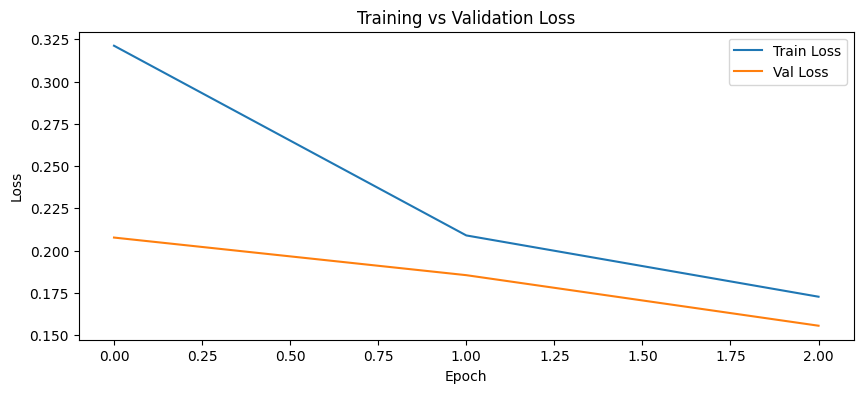

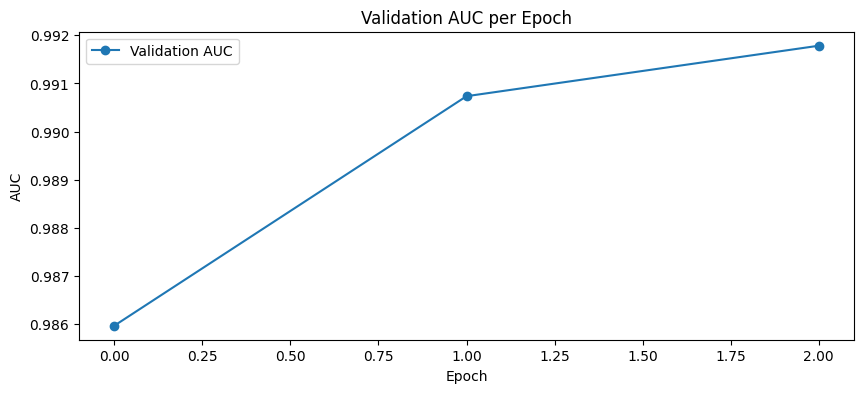

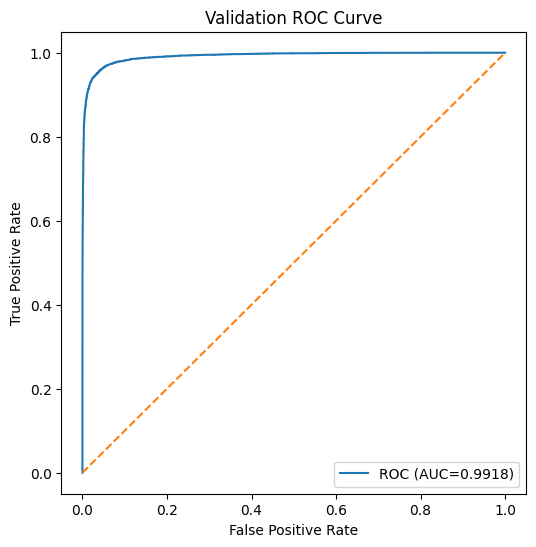

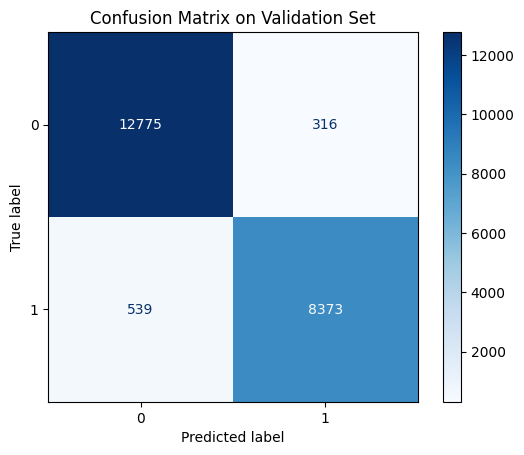

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

train_losses = list(globals().get("train_losses", []))
val_losses   = list(globals().get("val_losses", []))
val_aucs     = list(globals().get("val_aucs", []))

all_preds  = np.asarray(globals().get("all_preds")).ravel()
all_labels = np.asarray(globals().get("all_labels")).ravel()

best_threshold = float(globals().get("best_threshold", 0.5))

best_val_auc = float(max(val_aucs)) if len(val_aucs) else float(roc_auc_score(all_labels, all_preds))
final_val_loss = float(val_losses[-1]) if len(val_losses) else float("nan")

print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Chosen Threshold: {best_threshold:.2f}")

y_pred = (all_preds > best_threshold).astype(int)

acc = accuracy_score(all_labels, y_pred)
prec = precision_score(all_labels, y_pred, zero_division=0)
rec  = recall_score(all_labels, y_pred, zero_division=0)
f1   = f1_score(all_labels, y_pred, zero_division=0)
print(f"Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}")

if len(train_losses) and len(val_losses):
    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

if len(val_aucs):
    plt.figure(figsize=(10,4))
    plt.plot(val_aucs, marker="o", label="Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC per Epoch")
    plt.legend()
    plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(all_labels, all_preds):.4f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.show()

cm = confusion_matrix(all_labels, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Validation Set")
plt.show()

Our ResNet50 pipeline achieves AUC = 0.9911 on the validation set with a final validation loss of 0.1619.
Using the validation-tuned threshold 0.65 yields Precision 0.960, Recall 0.943, F1 0.951, and Specificity 0.973.
Loss curves show steady convergence, and the ROC curve indicates near-perfect separability.
The confusion matrix confirms low false positives (349) and low false negatives (512) at the chosen threshold, suggesting a balanced trade-off under the ~40% positive rate.

## Test-Time Augmentation and Inference
To enhance robustness at inference, we apply **Test-Time Augmentation (TTA)**.
Each test image is evaluated under multiple transformations (identity, horizontal
flip, vertical flip, rotation), and predictions are averaged. The optimal
threshold identified from validation is then applied to binarize probabilities
into final predictions.

This strategy stabilizes predictions and often improves leaderboard scores by
reducing variance due to single-view inference.


In [12]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as T

DATA_DIR   = globals().get("DATA_DIR", "/kaggle/input/histopathologic-cancer-detection")
IMG_SIZE   = int(globals().get("IMG_SIZE", 96))
BATCH_SIZE = int(globals().get("BATCH_SIZE", 128))
num_workers = int(globals().get("num_workers", 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_mem = device.type == "cuda"

sub_csv = os.path.join(DATA_DIR, "sample_submission.csv")
assert os.path.exists(sub_csv), f"Not found: {sub_csv}. Check DATA_DIR."
test_df = pd.read_csv(sub_csv, usecols=["id"])
test_df["id"] = test_df["id"].astype(str)

if "CancerDataset" not in globals():
    class CancerDataset(Dataset):
        def __init__(self, df, data_dir, mode="test"):
            self.df = df.reset_index(drop=True).copy()
            self.data_dir = data_dir
            self.tf = T.Compose([
                T.Resize((IMG_SIZE, IMG_SIZE)),
                T.ToTensor(),
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ])
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            img_id = str(self.df["id"].iat[idx])
            path = os.path.join(self.data_dir, "test", f"{img_id}.tif")
            img = Image.open(path).convert("RGB")
            return self.tf(img), img_id

test_ds = CancerDataset(test_df, DATA_DIR, mode="test")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_mem)

def _id(x):    return x
def _hflip(x): return torch.flip(x, dims=(-1,))
def _vflip(x): return torch.flip(x, dims=(-2,))
def _rot90(x): return torch.rot90(x, k=1, dims=(-2, -1))
TTA_FUNCS = [_id, _hflip, _vflip, _rot90]

model.eval().to(device)
amp = device.type == "cuda"

ids_out, probs_out = [], []
with torch.inference_mode():
    for imgs, ids in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        prob_sum = torch.zeros((imgs.size(0), 1), device=device)
        for fn in TTA_FUNCS:
            aug = fn(imgs).contiguous()
            with torch.amp.autocast(device_type="cuda", enabled=amp):
                logits = model(aug)
            prob_sum += torch.sigmoid(logits)
        probs = (prob_sum / len(TTA_FUNCS)).squeeze(1).detach().cpu().numpy()
        ids_out.extend(list(map(str, ids)))
        probs_out.extend(probs.tolist())

sub = pd.DataFrame({"id": ids_out, "label": probs_out}).sort_values("id")
sub.to_csv("submission.csv", index=False)
print(sub.shape, "-> saved to submission.csv")

(57458, 2) -> saved to submission.csv


## Discussion and Conclusion

We trained a ResNet50 on 96×96 patches with weighted sampling and a class-weighted BCE loss.  
On the validation split the model reached **AUC 0.9918** and **loss 0.1556**. Using a threshold chosen by an F1 sweep (**0.70**) gives **Precision 0.9636, Recall 0.9395, F1 0.9514, and Specificity 0.973**. Loss/AUC curves are stable and the confusion matrix shows balanced errors under ~40% positives.  

**What clearly helped:**  
1. ImageNet pretraining  
2. Handling imbalance with a weighted sampler + `pos_weight`  
3. Deterministic validation transforms and **4×TTA** at inference  

**Limitations:** only 3 epochs, a single backbone/loss, no stain normalization or cross-validation; patch-level labels limit slide-level interpretability.  

**Next steps:** try EfficientNet/ResNet101 or a small ensemble; add stain normalization (e.g., Macenko) and MixUp/CutMix; explore Focal/AUCPR-oriented losses and threshold calibration via CV; add calibration (EMA/SWA, temperature scaling) and simple explainability (Grad-CAM on FP/FN).
